This notebook uses [PyTorch](https://pytorch.org/), which is a library that can automatically differentiate functions and is commonly used to implement neural networks. Because of its capability to automatically differentiate functions, the formula for the gradient does not need to be manually derived -- this comes especially handy when working with neural networks, whose gradient formula can be quite complicated, especially for complex architectures. 

We recommend going over the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html) and then the starter code below. For any new functions that you come across, you can look up the documentation [here](https://pytorch.org/docs/stable/index.html). 

We recommend running this notebook on Google Colab to avoid having to install PyTorch and to take advantage of GPUs, which make training faster.

## Load packages

In [1]:
# load packages
# make sure to install the pacakge "tqdm" for the progress bar when training.
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.image as mpimg
from scipy import ndimage

path_prefix = ""

If running on Google Colab, you need to upload the file `autoencoder_starter.py`. To do so, you need to click on the folder icon on the left side of the page, which brings up a panel that would allow you to upload files. Note however uploading the file this way has a downside in that if your Python runtime times out or is otherwise restarted, the file will be erased and you will need to re-upload. 

If you would like to avoid this, you can create a directory named `CMPT_726Fall2021_A3` in your Google Drive and upload `autoencoder_starter.py` to that directory. Then execute the following block of code to mount your Google Drive. 

## Define your architecture here.

The `Autoencoder` class has several important functions unimplemented. You are required to implement the two sub-classes of `Encoder` and `Decoder`, i.e, the architecture and forward function of the encoder and decoder.


In [2]:
class Autoencoder(nn.Module):

    def __init__(self,dim_latent_representation=2):

        super(Autoencoder, self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                self.dense = nn.Linear(28*28, output_size, bias=True)

            def forward(self, x):
                out = self.dense(x)

                return out

        class Decoder(nn.Module):
            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                self.dense = nn.Linear(input_size, 28*28, bias=True)
                self.activation = nn.Tanh()

            def forward(self, z):
                out = self.dense(z)
                out = self.activation(out)
                return out

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    # Implement this function for the DAE model
    def add_noise(self, x, device, noise_type):
        if noise_type=='Gaussian':
            mu = 0.0
            std = 0.05 * torch.std(x)
            noise = torch.normal(mu, std, size = x.shape).to(device)
            x_noisy = x + noise
            
            return x_noisy

        elif noise_type=='Dropout':
            for i in range(x.size()[0]):
                features = x[i].size()[0]
                indices = np.random.choice(np.arange(features), replace=False, size=int(features * 0.05))
                x[i][indices] = 0

            return x

    # Implement this function for the VAE model
    # def reparameterise(self, mu, logvar):
    #     if self.training:
    #         # return reparametrized mu
    #     else:
    #         return mu

    def forward(self, x, device):
        # This function should be modified for the DAE and VAE
        x = self.add_noise(x, device, 'Dropout')
        x = self.encoder(x)
        x = self.decoder(x)
        # for the VAE forward function should also return mu and logvar
        return x


In [3]:
class VAE(nn.Module):
    
    def __init__(self,dim_latent_representation=2):

        super(VAE, self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                self.dense = nn.Linear(28*28, 1024, bias=True)
                self.mu_layer = nn.Linear(1024, output_size, bias=True)
                self.logvar_layer = nn.Linear(1024, output_size, bias=True)
                self.activation = nn.Tanh()

            def forward(self, x):
                out = self.dense(x)
                out = self.activation(out)
                mu = self.mu_layer(out)
                logvar = self.logvar_layer(out)
                z = VAE.reparameterise(self, mu, logvar)
                
                return z, mu, logvar

        class Decoder(nn.Module):
            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                self.dense = nn.Linear(input_size, 28*28, bias=True)
                self.activation = nn.Tanh()

            def forward(self, z):
                out = self.dense(z)
                out = self.activation(out)
                return out

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    # Implement this function for the VAE model
    def reparameterise(self, mu, logvar):
        if self.training:
            sigma = torch.exp(0.5 * logvar)
            normal_dist = torch.normal(torch.zeros_like(mu), torch.ones_like(sigma))
            return mu + sigma * normal_dist
        else:
            return mu

    def add_noise(self, x, device, noise_type):
        if noise_type=='Gaussian':
            mu = 0.0
            std = 0.3
            noise = torch.normal(mu, std, size = x.shape).to(device)
            x_noisy = x + noise
            
            return x_noisy

        elif noise_type=='Dropout':
            for i in range(x.size()[0]):
                features = x[i].size()[0]
                indices = np.random.choice(np.arange(features), replace=False, size=int(features * 0.3))
                x[i][indices] = 0

            return x

    def forward(self, x, device):
        # This function should be modified for the DAE and VAE
        x = self.add_noise(x, device, 'Dropout')
        x, mu, var = self.encoder(x)
        x = self.decoder(x)
        # for the VAE forward function should also return mu and logvar
        return x, mu, var

## Training the Model

The training loop is provided by the `Autoencoder_Trainer` class from `autoencoder_starter.py`.

In [4]:
from vae_starter import VAE_Trainer

LEARNING_RATE = 0.0005
EPOCH_NUMBER= 15 # the number of epochs and learning rate can be tuned.

autoencoder = VAE(dim_latent_representation=30)
trainer = VAE_Trainer(autoencoder_model=autoencoder,learning_rate=LEARNING_RATE,path_prefix=path_prefix)

try:
    for epoch in range(1, EPOCH_NUMBER + 1):
        trainer.train(epoch)
        trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
        print("Manual Interruption")

100%|██████████| 1875/1875 [00:22<00:00, 83.16it/s]


====> Epoch: 1 Average loss: 484.6351


100%|██████████| 313/313 [00:04<00:00, 63.08it/s] 


====> Val set loss (reconstruction error) : 431.3196


100%|██████████| 1875/1875 [00:22<00:00, 84.20it/s]


====> Epoch: 2 Average loss: 436.5489


100%|██████████| 313/313 [00:05<00:00, 60.10it/s] 


====> Val set loss (reconstruction error) : 418.7701


100%|██████████| 1875/1875 [00:22<00:00, 83.23it/s]


====> Epoch: 3 Average loss: 430.0793


100%|██████████| 313/313 [00:04<00:00, 64.62it/s] 


====> Val set loss (reconstruction error) : 416.3728


100%|██████████| 1875/1875 [00:22<00:00, 84.58it/s]


====> Epoch: 4 Average loss: 427.1749


100%|██████████| 313/313 [00:05<00:00, 62.37it/s] 


====> Val set loss (reconstruction error) : 413.6221


100%|██████████| 1875/1875 [00:22<00:00, 83.25it/s]


====> Epoch: 5 Average loss: 425.1409


100%|██████████| 313/313 [00:05<00:00, 58.59it/s] 


====> Val set loss (reconstruction error) : 411.8989


100%|██████████| 1875/1875 [00:24<00:00, 77.86it/s]


====> Epoch: 6 Average loss: 423.5671


100%|██████████| 313/313 [00:05<00:00, 58.17it/s] 


====> Val set loss (reconstruction error) : 410.5816


100%|██████████| 1875/1875 [00:23<00:00, 79.16it/s]


====> Epoch: 7 Average loss: 422.2922


100%|██████████| 313/313 [00:05<00:00, 58.36it/s] 


====> Val set loss (reconstruction error) : 409.2827


100%|██████████| 1875/1875 [00:23<00:00, 80.84it/s]


====> Epoch: 8 Average loss: 421.4637


100%|██████████| 313/313 [00:05<00:00, 61.12it/s] 


====> Val set loss (reconstruction error) : 409.9024


100%|██████████| 1875/1875 [00:23<00:00, 80.23it/s]


====> Epoch: 9 Average loss: 420.8916


100%|██████████| 313/313 [00:05<00:00, 57.25it/s] 


====> Val set loss (reconstruction error) : 409.4656


100%|██████████| 1875/1875 [00:22<00:00, 82.69it/s]


====> Epoch: 10 Average loss: 420.2925


100%|██████████| 313/313 [00:05<00:00, 58.90it/s] 


====> Val set loss (reconstruction error) : 410.3745


100%|██████████| 1875/1875 [00:22<00:00, 83.01it/s]


====> Epoch: 11 Average loss: 419.8852


100%|██████████| 313/313 [00:05<00:00, 61.13it/s] 


====> Val set loss (reconstruction error) : 408.7312


100%|██████████| 1875/1875 [00:22<00:00, 84.21it/s] 


====> Epoch: 12 Average loss: 419.4494


100%|██████████| 313/313 [00:05<00:00, 60.26it/s] 


====> Val set loss (reconstruction error) : 407.8034


100%|██████████| 1875/1875 [00:23<00:00, 79.45it/s]


====> Epoch: 13 Average loss: 419.2534


100%|██████████| 313/313 [00:05<00:00, 56.43it/s] 


====> Val set loss (reconstruction error) : 408.2044


100%|██████████| 1875/1875 [00:23<00:00, 80.26it/s]


====> Epoch: 14 Average loss: 418.9818


100%|██████████| 313/313 [00:05<00:00, 57.00it/s] 


====> Val set loss (reconstruction error) : 410.1890


100%|██████████| 1875/1875 [00:22<00:00, 82.17it/s]


====> Epoch: 15 Average loss: 418.7314


100%|██████████| 313/313 [00:05<00:00, 58.87it/s] 

====> Val set loss (reconstruction error) : 408.2623


If in the above cell, you find that the download of the dataset is unsuccessful because the server is down, you can also download the data from Canvas and put the data in the same directory of this notebook and `autoencoder_starter.py`. If you are running this notebook on Google Colab, you can create a directory called `CMPT_726Fall2021_A3` in your Google Drive and put the data directory you downloaded from Canvas inside. Then if you haven't mounted your Google Drive earlier using the block of code above, mount Google Drive by executing the following block of code.

## Visualizing 2D Bottleneck Feature Representations

We can visualize the 2D bottleneck representations of data points and their ground truth class labels with a scatter plot.

The `scatter_plot` function takes the following arguments:
* latent_presentations - (N, dimension_latent_representation) numpy array
* labels - (N, ) numpy array: the labels of the ground truth classes

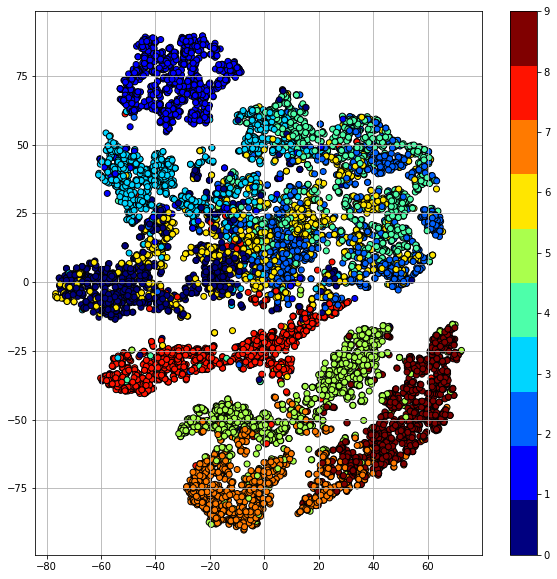

In [6]:
from sklearn import manifold

def scatter_plot_test(latent_representations, labels):
    '''
    the scatter plot for visualizing the latent representations with the ground truth class label
    ----------
    latent_presentations: (N, dimension_latent_representation)
    labels: (N, )  the labels of the ground truth classes
    '''

    # borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a

    # Note that if the dimension_latent_representation > 2 you need to apply TSNE transformation
    # to map the latent representations from higher dimensionality to 2D
    # You can use #from sklearn.manifold import TSNE#

    def discrete_cmap(n, base_cmap=None):
        """Create an N-bin discrete colormap from the specified input map"""
        base = plt.cm.get_cmap(base_cmap)
        return base.from_list(base.name + str(n), base(np.linspace(0, 1, n)), n)

    tsne = manifold.TSNE(
        n_components=2, init="random", random_state=0, perplexity=30
    )
    latent_representations = tsne.fit_transform(latent_representations)
    plt.figure(figsize=(10, 10))
    plt.scatter(latent_representations[:, 0], latent_representations[:, 1], cmap=discrete_cmap(10, 'jet'), c=labels,
                edgecolors='black')
    plt.colorbar()
    plt.grid()
    plt.show()

with torch.no_grad():
    model = trainer.model
    model.eval()
    z=[];label=[]
    for x,y in trainer.val_loader:
        x = x.view(-1, 28 * 28)
        z_, _, _ = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)

from autoencoder_starter import scatter_plot
scatter_plot_test(latent_representations=z,labels=label)


## Generating Images by Sampling Bottleneck Features

So here we can generate new images by sampling bottleneck features, and use the decoder to generate images. 

The code below provides an example of how to generate images by sampling bottleneck features. 

The `display_images_in_a_row` takes the following arguments:
* images: (N,28,28): N images of 28*28 as a numpy array
* file_path: file path name for where to store the figure
* display: display the image or not


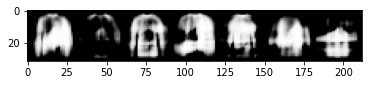

In [7]:
with torch.no_grad():
    samples = torch.randn(7, 30).to(trainer.device)
    samples = trainer.model.decoder(samples).cpu()

images = samples

from autoencoder_starter import display_images_in_a_row
display_images_in_a_row(images)

## Reconstructing Images

We can first retrieve the validation set and then pick 64 images (the first 64 images, though you can do it randomly).

We use the autoencoder to reconstruct the images and visualize them below.

Original images


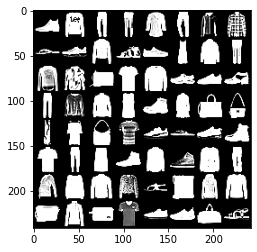

In [8]:
images = trainer.get_val_set() # get the entire validation set
total_number = 64
images = images[:total_number]

from autoencoder_starter import display_images_in_a_row
print("Original images")
display_images_in_a_row(images.cpu())

Reconstructed images


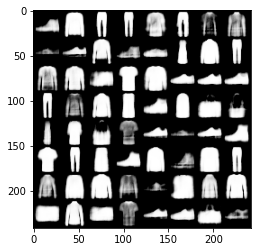

In [9]:
with torch.no_grad():
    images = images.view(-1, 28 * 28)
    images = images.to(trainer.device)
    reconstructed, _, _ = trainer.model(images, trainer.device)
    reconstructed = reconstructed.cpu().view(-1, 28, 28)
print("Reconstructed images")
display_images_in_a_row(reconstructed)